In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "ViT.ipynb"
#!python setup.py develop 
#!pip install wandb
#!pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer
#!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [2]:
import json, glob, random, re, collections, time, cv2, torch

import numpy as np
import wandb as wb
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from scipy.io import loadmat as lm
from enum import Enum
from torch import nn
from torch.utils import data as torch_data
from sklearn.model_selection import train_test_split
from torch.nn import functional as torch_functional
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from monai.networks import nets
from monai.data import (
    DataLoader,
    ImageDataset,
    ArrayDataset,
)
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
    LoadImage,
    Orientation,
    RandFlip,
    RandShiftIntensity,
    Spacing,
)
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

wandb: Currently logged in as: aalbizu (woodslab). Use `wandb login --relogin` to force relogin


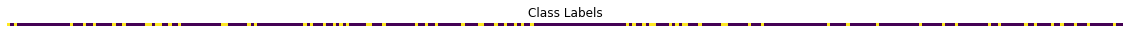

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/'
anatDir = '/blue/camctrp/working/gullettj/ACT/organized_data/';
funcDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/func/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
mri_types = ['T1'] # 'EPI'
T1_SIZE = (256,256,256) # MUST BE ISOMETRIC
T1_PATCH = (64,64,64) # MUST BE ISOMETRIC
EPI_SIZE = (51,51,1)
EPI_PAT = (17,17,1)
BATCH_SIZE = 17
N_EPOCHS = 50
SEED = 42
LEARNING_RATE = 1e-4
WEIGHT_DECAY=1e-5
reg = 1
LR_DECAY = 1e-10
depth = 12; # HARDCODED
heads = 12; # HARDCODED
dropout = 0.1; # HARDCODED
samples_to_exclude = np.array([103744,106986,300142,101644,105903,106078,106817,101395,105554,204085])
exclude = np.equal(np.isin(sdata[:,0],samples_to_exclude),0)
regs = ['','c']

num_of_cores = int(os.environ['SLURM_CPUS_PER_TASK'])

# Two binary labels for Healthy vs pre-MCI
subIdx = np.arange(sdata[exclude,0].shape[0]);
lab = np.array([sdata[:,1]]);
lab = lab[:,exclude]; 
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).float()

# MPRAGE Data
T1w_images = np.array([os.path.join(anatDir,''.join(['sub-',str(sdata[s,0])]),'ses-01','anat',''.join([regs[reg],'sub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
T1w_images = T1w_images[exclude]; # Remove 20ch Head Coils

# BOLD Data 
EPI_images = np.array([os.path.join(funcDir,''.join(['sub-',str(sdata[s,0]),'_ROIconnectivity.csv'])) for s in range(sdata.shape[0])]);
EPI_images = EPI_images[exclude]; # Remove 20ch Head Coils
EPI = np.zeros((EPI_images.shape[0],EPI_SIZE[0],EPI_SIZE[1])) # Pre-allocate
for s in range(EPI_images.shape[0]):
    EPI[s,:,:] = np.genfromtxt(EPI_images[s], delimiter=',')
    
class Diagnosis(Enum):
    normal = 0
    preMCI = 1

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

T1 Shape: (176, 256, 256) 
CONN Shape: (51, 51)


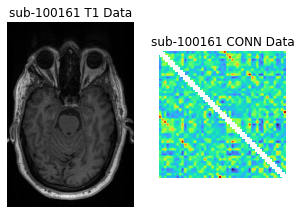

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)    

# Plot OG Images
fig, axes = plt.subplots(*[1,2], figsize=(5, 5), facecolor="white")

# T1w
axes[0].set_title(''.join(['sub-',str(sdata[0,0]),' T1 Data']));
nii = nib.load(T1w_images[0]); # Load Each Electrode
axes[0].imshow(nii.get_fdata()[:, :, 100].T, cmap="gray", origin="lower"); axes[0].axis('off'); 
# EPI
axes[1].set_title(''.join(['sub-',str(sdata[0,0]),' CONN Data']));
mat = pd.read_csv(EPI_images[0],delimiter=',',header=None); # Load Each Electrode
axes[1].imshow(mat, cmap="turbo"); axes[1].axis('off');
print('T1 Shape:',nii.shape,'\nCONN Shape:',mat.shape)

In [5]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    """Attention mechanism
    
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features
        
    heads : int
        Number of attention heads
    
    qkv_bias : bool
        If True, then we include bias to the query, key, and value projections
    
    attn_p : float
        Dropout probability applied to the query, key, and value tensors
    
    proj_p : float
        Dropout probability applied to the output tensor
    
    Attributes
    ----------
    scale : float 
        Normalizing constant for the dot product
    to_qkv : nn.Linear
        Linear projection for the query, key, and value
    to_out : nn.Linear 
        Linear mapping that takes tin the concatenated output of all attention heads and maps it into a new space
    attn_drop : nn.Dropout
        Dropout Layers
    """
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        """Run forward pass
        
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)` # +1 since class token is always first
        
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)` # same as above
        """
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer Block
    
    Parameters
    ----------
    dim : int
        Embedding dim
    
    heads : int
        Number of attn heads
        
    mlp_ratio : float
        Determine the hidden dimension size of the MLP with respect to dim
        
    qkv_bias : bool
        If True, then we include bias to the query, key, and value projection
    
    dropout : float 
        Dropout probability
    
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization
        
    attn : Attention
        Attention module
    
    mlp : MLP
        MLP module
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
#         mlp_dim = 2048 # HARDCODED
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
            
    def forward(self, x):
        """Run forward pass
        
        Parameters
        ----------
        x : torch.Tensor
            Shape `n_samples, n_patches + 1, dim
        
        Returns
        -------
        torch.Tensor
            Shape `n_samples, n_patches + 1, dim
        """
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class Model(nn.Module):
    """Simplified implemetation of the Vision Transformer
    
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square)
        
    patch_size : int
        Size of patch (it is a square)
    
    in_chans : int
        Number of channels
        
    n_classes : int
        Number of classes
        
    embed_dim : int
        Dimesionality of the token/patch embeddings
    
    depth : int
        Number of blocks
    
    n_heads : int
        Number of attention heads
        
    mlp_ratio : float
        Determines the hidden dimensions of the MLP module
    
    qkv_bias : bool
        If True, then we include bias to the query, key, and vlue projections
        
    p, attn_p : float
        Dropout probability
    
    Attributes
    ----------
    patch_to_embedding : PatchEmbed
        Patch embedding layer
        
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence. It has embed_dim elements
        
    pos_embedding : nn.Parameter
        Positional embedding of the cls token + all the patches. It has `n_patches + 1 * embed_dim` elements
    
    dropout : nn.Dropout
        Dropout layer
        
    """
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size[0] % patch_size[0] == 0, 'image dimensions must be divisible by the patch size'
        num_patches = int(np.prod(np.divide(image_size,patch_size))); # 3D
        patch_dim = channels * np.prod(patch_size)

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # Position Embedding
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
            nn.Dropout(dropout)  
        )

    def forward(self, img, mask = None):
        """Run forward pass
        
        Parameters
        ----------
        x : torch.Tensor
            Shape `n_samples, in_chans, img_size, img_size`
        
        Returns
        -------
        logits : torch.Tensor
            Logits over all classes - `n_classes, n_classes`
        """
        p = self.patch_size # PAT_SIZE 1D
        x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1 = p[0], p2 = p[1], p3 = p[2]) # SPLIT IMAGE INTO 3D PATCHES (b, # patchs, # patch features)
        x = self.patch_to_embedding(x) # Patch Embedding
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding # Patch Embbeding + Position Embedding
        x = self.dropout(x)

        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0]) # class token
        return self.mlp_head(x)

In [6]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer,
        criterion
    ):
        self.model = model
        self.device = device
        self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)                          
        self.criterion = criterion

        self.best_valid_score = 0.0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []

    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            # Train
            train_loss, train_time = self.train_epoch(train_loader)
            wb.log({'train_loss': train_loss, 'train_time': train_time})
            self.train_losses.append(train_loss)
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            # Validation
            if epochs > 100: 
                val_int = epochs/10 # Validate every 10 epochs
            elif epochs <= 100:
                val_int = 1 # Validate every epoch
            if n_epoch % val_int == 0:
                valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                wb.log({'valid_loss': valid_loss, 'valid_auc': valid_auc, 'valid_time': valid_time})
                self.val_losses.append(valid_loss)
                self.val_auc.append(valid_auc)

                self.info_message(
                    "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                    n_epoch, valid_loss, valid_auc, valid_time
                )

                if self.best_valid_score < valid_auc:
                    try: 
                        os.remove(self.lastmodel)
                    except:
                        pass
                    self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                    self.info_message(
                         "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                        self.best_valid_score, valid_auc, self.lastmodel
                    )
                    self.best_valid_score = valid_auc
                    self.n_patience = 0
                else:
                    self.n_patience += 1
            
                if self.n_patience >= patience:
                    self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                    break
        
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch[0].clone().float().to(self.device);
            targets = batch[1].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets.float())            
            self.scaler.scale(loss).backward()
#             loss.backward()

            sum_loss += loss.detach().item()
            self.scaler.step(self.optimizer)
            self.scaler.update()
#             self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch[1].to(self.device)

                output = self.model(batch[0].clone().detach().float().to(self.device)).squeeze(1)
                loss = self.criterion(output, targets.float())
                sum_loss += loss.detach().item()
                output = torch.sigmoid(output)
                
                y_all.extend(batch[1].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [7]:
nontest_list, test_list = train_test_split(subIdx, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
nontest_label, test_label = train_test_split(lab.T, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
train_list, valid_list = train_test_split(nontest_list, 
                                          
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED);

# Oversampling the Unbalnaced Class
train_list = np.array(np.hstack([[train_list[train_label[:,0] == 1].T],[train_list.T]]))[0,:]; 
train_label = np.array([np.int64(np.hstack([train_label[train_label[:,0]==1,0],train_label[:,0]]))]).T;

print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
del nontest_list, nontest_label; # Save RAM

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train case split:  114 : 232
valid case split:  6 : 27
test case split:  3 : 14 



EPOCH: 1
[Epoch Train: 1] loss: 0.7162, time: 74.00 s
[Epoch Valid: 1] loss: 0.5244, auc: 0.5370, time: 13.00 s
auc improved from 0.0000 to 0.5370. Saved model to '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/T1-e1-loss0.524-auc0.537.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.6438, time: 67.00 s
[Epoch Valid: 2] loss: 0.5244, auc: 0.5370, time: 10.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6364, time: 71.00 s
[Epoch Valid: 3] loss: 0.5244, auc: 0.5370, time: 10.00 s
EPOCH: 4
[Epoch Train: 4] loss: 0.6403, time: 68.00 s
[Epoch Valid: 4] loss: 0.5244, auc: 0.5370, time: 9.00 s
EPOCH: 5
[Epoch Train: 5] loss: 0.6462, time: 74.00 s
[Epoch Valid: 5] loss: 0.5244, auc: 0.5370, time: 10.00 s
EPOCH: 6
[Epoch Train: 6] loss: 0.6352, time: 71.00 s
[Epoch Valid: 6] loss: 0.5244, auc: 0.5370, time: 10.00 s
EPOCH: 7
[Epoch Train: 7] loss: 0.6239, time: 78.00 s
[Epoch Valid: 7] loss: 0.5244, auc: 0.5370, time: 9.00 s
EPOCH: 8
[Epoch Train: 8] loss: 0.6394, time: 70.00 s
[Epoch Valid: 8] loss: 0.5244, 

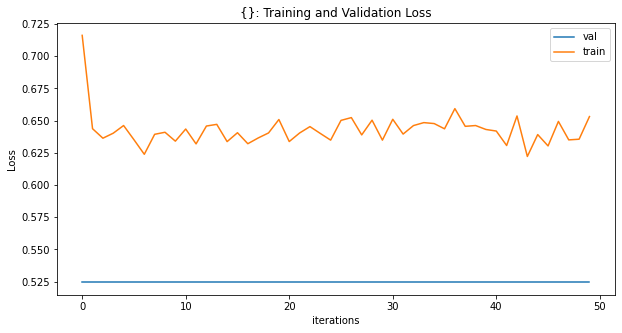

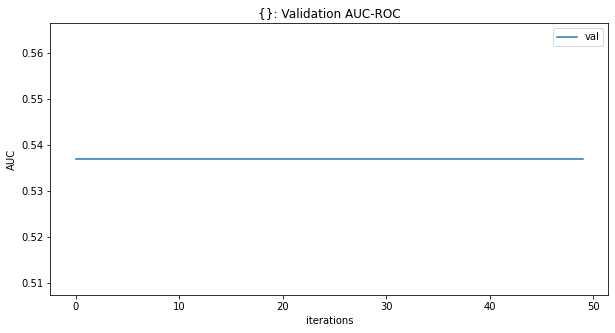

['/blue/camctrp/working/gullettj/ACT/derivatives/SVM/T1-e1-loss0.524-auc0.537.pth']
Predict: /blue/camctrp/working/gullettj/ACT/derivatives/SVM/T1-e1-loss0.524-auc0.537.pth T1 (17,)


test_acc,▁
test_auc,▁
train_loss,█▃▂▂▂▁▂▂▃▂▃▃▂▂▂▂▂▂▃▂▃▃▂▃▃▂▃▃▃▄▃▃▂▂▃▁▂▃▂▃
train_time,▆▂▄▂▄█▃▅▃▂▄▃▅▃▆▃▅▃▃▆▄▃▁▅▆▂▃▂▃▄▃▃▄▂▃▇▂▃▄▅
valid_auc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_time,█▄▄▂▄▂▁▄▄▂▁▂▄▂▂▄▁▇▁▁▂▂▁▁▂▄▁▁▄▂▂▁▂▂▄▁▄▁▂▁
test_acc,0.82353
test_auc,0.52381
train_loss,0.65318
train_time,72


In [8]:
def train_mri_type(df_train, df_valid, train_lab, valid_lab, mri_type):
    sp = os.path.join(rootDir,mri_type); # Save Path
    if mri_type == 'T1':
        dim = T1_SIZE[0]*4; # HARDCODED
        mlp_dim = T1_SIZE[0]*8; # HARDCODED
        
        # Define transforms
        train_transforms = Compose([
            AddChannel(),
            RandFlip(
                spatial_axis=[0],                   
                prob=0.10,
            ),
            RandFlip(
                spatial_axis=[1],
                prob=0.10,
            ),
            RandFlip(
                spatial_axis=[2],
                prob=0.10,
            ),
            RandRotate90(
                prob=0.10,
                max_k=3,
            ),
            RandShiftIntensity(
                offsets=0.10,
                prob=0.50,
            ),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), # HARDCODED
                mode="bilinear",
                image_only=True,
            ),    
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),        
            ScaleIntensity(
                minv=0.0,
                maxv=1.0,
            ),
            Resize(T1_SIZE),
            EnsureType(data_type='tensor'),
        ]);
        train_ds = ImageDataset(image_files=T1w_images[df_train], labels=train_lab[:,0], transform=train_transforms);
        
#         model = nets.ViT(in_channels=1, img_size=T1_SIZE, patch_size=T1_PATCH, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1, # HARDCODED
        dim = dim,
        depth = depth,
        heads = heads, 
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    elif mri_type == 'EPI':
        dim = EPI_SIZE[0]*4; # HARDCODED
        mlp_dim = EPI_SIZE[0]*8; # HARDCODED
        
        # Define transforms
        train_transforms = Compose([]); ######################################## EMPTY ##############################################
        train_ds = ArrayDataset(img=EPI[df_train,:,:], labels=train_lab[:,0], img_transform=train_transforms);
        
#         model = nets.ViT(in_channels=1, img_size=EPI_SIZE, patch_size=EPI_PAT, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1, # HARDCODED
        dim = dim,
        depth = depth,
        heads = heads,
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_of_cores, pin_memory=pin_memory);

    # create a validation data loader
    if mri_type == 'T1':
        dim = T1_SIZE[0]*4; # HARDCODED
        mlp_dim = T1_SIZE[0]*8; # HARDCODED
        
        val_transforms = Compose([
            AddChannel(),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), 
                mode="bilinear", 
                image_only=True,
            ),
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),
            ScaleIntensity(
                minv=0.0, 
                maxv=1.0, 
            ),
            Resize(T1_SIZE),
            EnsureType(data_type='tensor'),
        ]);
        valid_ds = ImageDataset(image_files=T1w_images[df_valid], labels=valid_lab[:,0], transform=val_transforms);
        
#         model = nets.ViT(in_channels=1, img_size=T1_SIZE, patch_size=T1_PATCH, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1, # HARDCODED
        dim = dim,
        depth = depth,
        heads = heads,
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    elif mri_type == 'EPI':
        dim = EPI_SIZE[0]*4; # HARDCODED
        mlp_dim = EPI_SIZE[0]*8; # HARDCODED
        
        val_transforms = Compose([]); ######################################## EMPTY ##############################################
        valid_ds = ArrayDataset(img=EPI[df_valid,:,:], labels=valid_lab[:,0], img_transform=val_transforms);
        
#         model = nets.ViT(in_channels=1, img_size=T1_SIZE, patch_size=T1_PATCH, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1, # HARDCODED
        dim = dim,
        depth = depth,
        heads = heads,
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=num_of_cores, pin_memory=pin_memory)
   
    model.to(device)
    
    wb.init(project="ACT-ViT",
           config={
               "batch_size": BATCH_SIZE,
               "Num_Epochs": N_EPOCHS,
               "T1_size": T1_SIZE,
               "T1_Patch": T1_PATCH,
               "EPI_size": EPI_SIZE,
               "EPI_Patch": EPI_PAT,
               "Embed Dims": dim,
               "Transformer Depth": depth,
               "N_Attn_Heads": heads,
               "mlp_dim": mlp_dim,
               "Registration": reg,
               "learning_rate": LEARNING_RATE,
               "lr_decay": LR_DECAY,
               "Weight_Decay": WEIGHT_DECAY,
               "RNG_Seed": SEED,
               "dataset": "ACT"
           }, entity="woodslab")
        
    wb.watch(model, log='all')

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
#     criterion = torch.nn.CrossEntropyLoss() # Vision Transformer
    criterion = torch_functional.binary_cross_entropy_with_logits # DenseNet

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        sp, 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

######## ENSEMBLE TRAINING LOOP #######

modelfiles = None
if not modelfiles:
    modelfiles = [train_mri_type(train_list, valid_list, train_label, valid_label, m) for m in mri_types]
    print(modelfiles)

######## ENSEMBLE INFERENCE ########

def predict(modelfile, df, lab, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    
    if mri_type == 'T1':
        dim = T1_SIZE[0]*4; # HARDCODED
        mlp_dim = T1_SIZE[0]*8; # HARDCODED
        
        val_transforms = Compose([
            AddChannel(),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), 
                mode="bilinear", 
                image_only=True,
            ),
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),
            ScaleIntensity(
                minv=0.0, 
                maxv=1.0, 
            ),
            Resize(T1_SIZE),
            EnsureType(data_type='tensor'),
        ]);
        val_ds = ImageDataset(image_files=T1w_images[df], labels=lab, transform=val_transforms);
        
#         model = nets.ViT(in_channels=1, img_size=T1_SIZE, patch_size=T1_PATCH, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = T1_SIZE,
        patch_size = T1_PATCH,
        num_classes = 1, # HARDCODED
        dim = dim,
        depth = depth,
        heads = heads,
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    elif mri_type == 'EPI':
        dim = EPI_SIZE[0]*4
        mlp_dim = EPI_SIZE[0]*8
        
        val_transforms = Compose([]); ######################################## EMPTY ##############################################
        val_ds = ArrayDataset(img=EPI[df,:,:], labels=lab, img_transform=val_transforms)
        
#         model = nets.ViT(in_channels=1, img_size=T1_SIZE, patch_size=T1_PATCH, hidden_size=dim, mlp_dim=mlp_dim, 
#                         num_layers=depth, num_heads=heads, pos_embed='conv', classification=True, num_classes=1, 
#                         dropout_rate=dropout, spatial_dims=3)
        
        model = Model(
        image_size = EPI_SIZE,
        patch_size = EPI_PAT,
        num_classes = 1, # HARDCODED
        dim = dim, 
        depth = depth,
        heads = heads, 
        mlp_dim = mlp_dim,
        channels = 1, # HARDCODED
        dropout = dropout,
        emb_dropout = dropout
        )

    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=num_of_cores, pin_memory=pin_memory)
   
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    for e, batch in enumerate(val_loader,1):
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch[0].clone().detach().float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
    return y_pred

# Pre-Allocate
y_pred = np.array([])
y_prob = np.array([])
y = np.array([])
test_acc = 0

# Prediction Loop
for m, mtype in zip(modelfiles,  mri_types):
    prob = predict(m, test_list, test_label[:,0], mtype, "valid");
    test_acc += np.mean((np.array(prob)>0.5) == test_label[:,0]);
    y_prob = np.concatenate([y_prob, prob], axis=0)
    y_pred = np.concatenate([y_pred, np.array(prob)>0.5], axis=0)
    y = np.concatenate([y, test_label[:,0]], axis=0);
    
# Average
test_acc /= len(modelfiles);
auc = roc_auc_score(y, y_prob)

# Log
wb.log({'test_acc': test_acc,'test_auc': auc})
wb.run.log_code(root=os.path.join(os.getcwd(),"ViT.ipynb"));
wb.finish() # Stop W&B log

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

      normal       0.82      1.00      0.90        14
      preMCI       0.00      0.00      0.00         3

    accuracy                           0.82        17
   macro avg       0.41      0.50      0.45        17
weighted avg       0.68      0.82      0.74        17

Test Accuracy: 82.35% - Test AUC: 0.523810


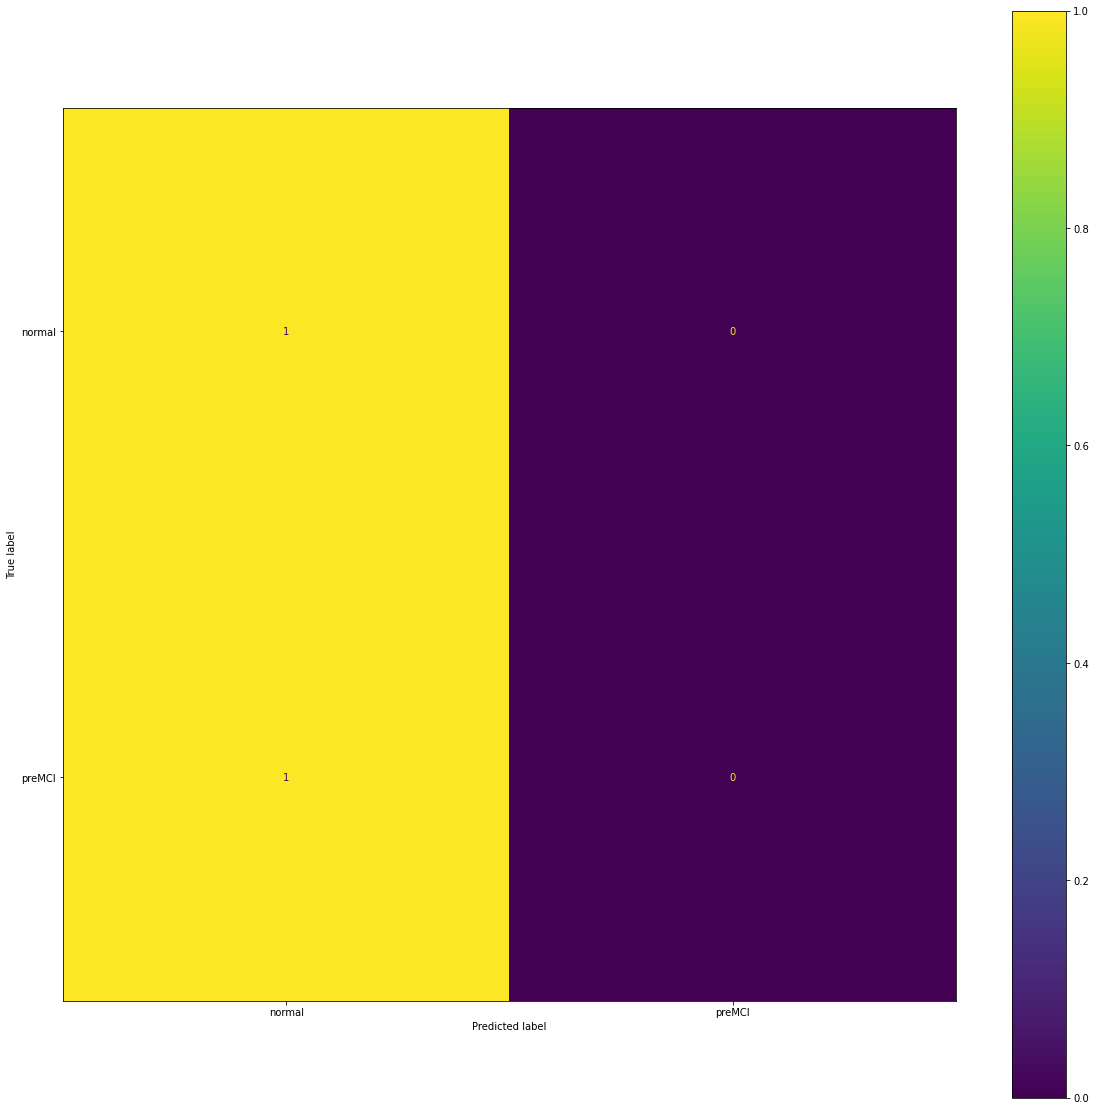

In [9]:
##### Plot Confusion Matrix #####

print(classification_report(
    y,
    y_pred,
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y,
    y_pred,
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])
print(f"Test Accuracy: {np.mean(y == (y_prob>0.5))*100:.2f}% - Test AUC: {auc:.6f}")